In [1]:
import numpy as np

In [2]:
class Loader(object):
    def __init__(self, path, count):
        # count: the sample number 
        self.path = path
        self.count = count
    def get_file_content(self):
        f = open(self.path, 'rb')
        content = f.read()   # 读取字节流
        f.close()
        return content   # 放回字节数组

In [3]:
class ImageLoader(Loader):
    # 从文件数组中获取第index个图片数据
    def get_picture(self, content, index):
        start = index*28*28 + 16  # 文件头16个字节，后面每28*28个字节跟一个图片数据
        picture = []
        for i in range(28):
            picture.append([])
            for j in range(28):
                byte = content[start + i*28 + j]
                picture[i].append(byte)
        return picture
    # 获取一个图像数据sample，这里需要将图片转换成为784行向量的形式
    def get_one_sample(self, picture):
        sample = []
        for i in range(28):
            for j in range(28):
                sample.append(picture[i][j])
        return sample
    # 加载数据文件，获取全部样本向量。onerow来表示是否转化成为一行向量
    def load(self, onerow = False):
        content = self.get_file_content()
        data_set = []
        for index in range(self.count):
            onepic = self.get_picture(content, index)
            if onerow : onepic = self.get_one_sample(onepic)
            data_set.append(onepic)
        return data_set

In [4]:
# 数据标签加载器
class LabelLoader(Loader):
    def load(self):
        content = self.get_file_content()
        labels = []
        for index in range(self.count):
            onelable = content[index + 8] # 文件头有8个字节
            onelablevec = self.norm(onelable)
            labels.append(onelablevec)
        return labels
    def norm(self, label):
        label_vec = []
        for i in range(10):
            if i == label:
                label_vec.append(0.9)
            else:
                label_vec.append(0.1)
        return label_vec

In [5]:
# 获取训练数据集, onerow表示是否转化为行向量
def get_training_data_set(num, onerow = False):
    image_loader = ImageLoader("train-images.idx3-ubyte", num)
    label_loader = LabelLoader("train-labels.idx1-ubyte", num)
    return image_loader.load(onerow), label_loader.load()
def get_test_data_set(num, onerow = False):
    image_loader = ImageLoader("t10k-images.idx3-ubyte", num)
    label_loader = LabelLoader("t10k-labels.idx1-ubyte", num)
    return image_loader.load(onerow), label_loader.load()

In [6]:
# 定义一个函数，将784行向量打印出来
def printImg(onepic):
    onepic = onepic.reshape(28, 28)
    for i in range(28):
        for j in range(28):
            if onepic[i][j] == 0 :
                print(" ", end = '')
            else :
                print("*", end = '')
        print('')

In [7]:
if __name__ == "__main__":
    train_data_set, train_data_label = get_training_data_set(100)
    train_data_set = np.array(train_data_set)
    train_data_labels = np.array(train_data_label)
    for i in range(10):
        onepic = train_data_set[i]
        printImg(onepic)
        print(train_data_labels[i].argmax())

                            
                            
                            
                            
                            
            ************    
        ****************    
       ****************     
       ***********          
        ******* **          
         *****              
           ****             
           ****             
            ******          
             ******         
              ******        
               *****        
                 ****       
              *******       
            ********        
          *********         
        **********          
      **********            
    **********              
    ********                
                            
                            
                            
5
                            
                            
                            
                            
               *****        
              ******        
            

### 建立全连接网络模块

In [35]:
import random
import numpy as np
import datetime

In [35]:
# 1. 当为array的时候，默认d*f就是对应元素的乘积，multiply也是对应元素的乘积，dot（d,f）会转化为矩阵的乘积， dot点乘意味着相加，而multiply只是对应元素相乘，不相加
# 2. 当为mat的时候，默认d*f就是矩阵的乘积，multiply转化为对应元素的乘积，dot（d,f）为矩阵的乘积

# Sigmoid激活函数类
class SigmoidActivator(object):
    def forward(self, weighted_input): #前向传播计算输出
        try:
            result =  1.0 / (1.0 + np.exp(-weighted_input))    
        except RuntimeWarning as identifier:
            print(weighted_input)
        return result
        
    def backward(self, output):  #后向传播计算导数
        return np.multiply(output,(1 - output))   # 对应元素相乘

In [35]:
# 全连接每层的实现类。输入对象x、神经层输出a、输出y均为列向量
class FullConnectedLayer(object):
    # 构造函数。input_size: 本层输入向量的维度。output_size: 本层输出向量的维度。activator: 激活函数
    def __init__(self, input_size, output_size,activator):
        self.input_size = input_size
        self.output_size = output_size
        self.activator = activator
        # 权重数组W
        self.W = np.random.uniform(-0.1, 0.1,(output_size, input_size))  #初始化为-0.1~0.1之间的数。权重的大小。行数=输出个数，列数=输入个数。a=w*x，a和x都是列向量
        # 偏置项b
        self.b = np.zeros((output_size, 1))  # 全0列向量偏重项
        # 输出向量
        self.output = np.zeros((output_size, 1)) #初始化为全0列向量
    # 前向计算，预测输出。input_array: 输入向量，维度必须等于input_size
    def forward(self, input_array):   # 式2
        self.input = input_array
        self.output = self.activator.forward(np.dot(self.W, input_array) + self.b)

    # 反向计算W和b的梯度。delta_array: 从上一层传递过来的误差项。列向量
    def backward(self, delta_array):
        # 式8
        self.delta = np.multiply(self.activator.backward(self.input),np.dot(self.W.T, delta_array))   #计算当前层的误差，已被上一层使用
        self.W_grad = np.dot(delta_array, self.input.T)   # 计算w的梯度。梯度=误差.*输入
        self.b_grad = delta_array  #计算b的梯度

    # 使用梯度下降算法更新权重
    def update(self, learning_rate):
        self.W += learning_rate * self.W_grad
        self.b += learning_rate * self.b_grad

In [35]:
# 神经网络类
class Network(object):
    # 初始化一个全连接神经网络。layers:数组，描述神经网络每层节点数。包含输入层节点个数、隐藏层节点个数、输出层节点个数
    def __init__(self, layers):
        self.layers = []
        for i in range(len(layers) - 1):
            self.layers.append(FullConnectedLayer(layers[i], layers[i+1],SigmoidActivator()))   # 创建全连接层，并添加到layers中


    # 训练函数。labels: 样本标签矩阵。data_set: 输入样本矩阵。rate: 学习速率。epoch: 训练轮数
    def train(self, labels, data_set, rate, epoch):
        for i in range(epoch):
            for d in range(len(data_set)):
                # print(i,'次迭代，',d,'个样本')
                oneobject = np.array(data_set[d]).reshape(-1,1)   #将输入对象和输出标签转化为列向量
                onelabel = np.array(labels[d]).reshape(-1,1)
                self.train_one_sample(onelabel,oneobject, rate)

    # 内部函数，用一个样本训练网络
    def train_one_sample(self, label, sample, rate):
        # print('样本：\n',sample)
        self.predict(sample)  # 根据样本对象预测值
        self.calc_gradient(label) # 计算梯度
        self.update_weight(rate) # 更新权重

    # 使用神经网络实现预测。sample: 输入样本
    def predict(self, sample):
        sample = sample.reshape(-1,1)   #将样本转换为列向量
        output = sample  # 输入样本作为输入层的输出
        for layer in self.layers:
            # print('权值：',layer.W,layer.b)
            layer.forward(output)  # 逐层向后计算预测值。因为每层都是线性回归
            output = layer.output
        # print('预测输出：', output)
        return output

         # 计算每个节点的误差。label为一个样本的输出向量，也就对应了最后一个所有输出节点输出的值
    def calc_gradient(self, label):
        # print('计算梯度：',self.layers[-1].activator.backward(self.layers[-1].output).shape)
        delta = np.multiply(self.layers[-1].activator.backward(self.layers[-1].output),(label - self.layers[-1].output))  #计算输出误差
        # print('输出误差：', delta.shape)
        for layer in self.layers[::-1]:
            layer.backward(delta)   # 逐层向前计算误差。计算神经网络层和输入层误差
            delta = layer.delta
            # print('当前层误差：', delta.shape)
        return delta

    # 更新每个连接权重
    def update_weight(self, rate):
        for layer in self.layers:  # 逐层更新权重
            layer.update(rate)

In [35]:
# 根据返回结果计算所属类型
def valye2type(vec):
    return vec.argmax(axis=0)   # 获取概率最大的分类，由于vec是列向量，所以这里按列取最大的位置

In [35]:
# 使用错误率来对网络进行评估
def evaluate(network, test_data_set, test_labels):
    error = 0
    total = test_data_set.shape[0]
    for i in range(total):
        label = valye2type(test_labels[i])
        predict = valye2type(network.predict(test_data_set[i]))
        if label != predict:
            error += 1
    return float(error) / float(total)

In [39]:
if __name__ == '__main__':
    # 使用神经网络实现and运算
    data_set = np.array([[0,0],[0,1],[1,0],[1,1]])
    labels = np.array([[1,0],[1,0],[1,0],[0,1]])
    # print(data_set)
    # print(labels)
    net = Network([2,1,2])  # 输入节点2个（偏量b会自动加上），神经元1个，输出节点2个。
    net.train(labels, data_set, 2, 100)
    for layer in net.layers:  # 网络层总不包含输出层
        print('W:',layer.W)
        print('b:',layer.b)

    # 对结果进行预测
    for i in range(2):
        for j in range(2):
            sample = np.array([[i, j]])
            result = net.predict(sample)
            type = valye2type(result)
            print('分类：',type)

W: [[-3.76464073 -3.68851559]]
b: [[4.9756007]]
W: [[ 5.41960439]
 [-5.42313583]]
b: [[-2.04371404]
 [ 2.04526327]]
分类： [0]
分类： [0]
分类： [0]
分类： [1]


### 开始手写数字识别

In [41]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

样本数据集的个数：6000
测试数据集的个数：1000


C:\Users\LuoD\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


2018-08-06 12:13:31.022199 epoch 1 finished
2018-08-06 12:13:31.158228 after epoch 1, error ratio is 0.217000
2018-08-06 12:13:52.585273 epoch 2 finished
2018-08-06 12:13:52.741301 after epoch 2, error ratio is 0.175000
2018-08-06 12:14:12.202840 epoch 3 finished
2018-08-06 12:14:12.322728 after epoch 3, error ratio is 0.150000
2018-08-06 12:14:32.260771 epoch 4 finished
2018-08-06 12:14:32.391648 after epoch 4, error ratio is 0.140000
2018-08-06 12:14:51.442347 epoch 5 finished
2018-08-06 12:14:51.579217 after epoch 5, error ratio is 0.142000
2018-08-06 12:15:11.137910 epoch 6 finished
2018-08-06 12:15:11.306921 after epoch 6, error ratio is 0.126000
2018-08-06 12:15:30.989142 epoch 7 finished
2018-08-06 12:15:31.148990 after epoch 7, error ratio is 0.128000
2018-08-06 12:15:51.337736 epoch 8 finished
2018-08-06 12:15:51.451630 after epoch 8, error ratio is 0.121000
2018-08-06 12:16:11.617384 epoch 9 finished
2018-08-06 12:16:11.755253 after epoch 9, error ratio is 0.116000
2018-08-06

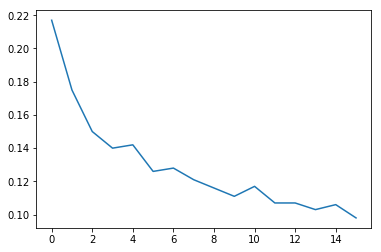

In [43]:
def train_and_evaluate():
    last_error_ratio = 1.0
    epoch = 0
    train_data_set, train_labels = get_training_data_set(6000,True)   # 加载训练样本数据集，和one-hot编码后的样本标签数据集
    test_data_set, test_labels = get_test_data_set(1000,True)   # 加载测试特征数据集，和one-hot编码后的测试标签数据集
    train_data_set=np.array(train_data_set)
    train_labels=np.array(train_labels)
    test_data_set=np.array(test_data_set)
    test_labels=np.array(test_labels)


    print('样本数据集的个数：%d' % len(train_data_set))
    print('测试数据集的个数：%d' % len(test_data_set))
    network = Network([784, 300, 10])  # 定义一个输入节点784+1，神经元300，输出10

    error_ratios = []
    while True:  # 迭代至准确率开始下降
        epoch += 1 # 记录迭代次数
        network.train(train_labels, train_data_set, 0.005, 1)  # 使用训练集进行训练。0.3为学习速率，1为迭代次数
        print('%s epoch %d finished' % (datetime.datetime.now(), epoch))  # 打印时间和迭代次数
        # if epoch  == 0:  # 每训练10次，就计算一次准确率
        error_ratio = evaluate(network, test_data_set, test_labels)  # 计算准确率
        error_ratios.append(error_ratio)
        print('%s after epoch %d, error ratio is %f' % (datetime.datetime.now(), epoch, error_ratio))  # 打印输出错误率
        if error_ratio < 0.1:  # 设置终止条件，正确率大于90%时停止
            break
    index=0
    for layer in network.layers:
        np.savetxt('MNIST—W'+str(index),layer.W)
        np.savetxt('MNIST—b' + str(index), layer.b)
        index+=1
        # 把模型参数存储起来
        # print(layer.W)
        # print(layer.b)
    plt.plot(list(range(len(error_ratios))), error_ratios)
    plt.show()

if __name__ == '__main__':
    train_and_evaluate()   # 使用样本数据集进行预测